In [1]:
%load_ext line_profiler

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

In [3]:
import warnings
warnings.filterwarnings('error')

In [4]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)
with open('save/plt_agl_est','rb') as f:
    plt_agl_est = pickle.load(f)
with open('save/plt_ag', 'rb') as f:
    plt_ag = pickle.load(f)
with open('save/plt_agl', 'rb') as f:
    plt_agl = pickle.load(f)
with open('save/plt_ag_sw', 'rb') as f:
    plt_ag_sw = pickle.load(f)
with open('save/plt_agl_est_sw', 'rb') as f:
    plt_agl_est_sw = pickle.load(f)
with open('save/plt_agl_sw', 'rb') as f:
    plt_agl_sw = pickle.load(f)
with open('save/plt_ucbl_est', 'rb') as f:
    plt_ucbl_est = pickle.load(f)
with open('save/plt_ucb', 'rb') as f:
    plt_ucb = pickle.load(f)

In [5]:
records = pd.concat([pd.read_csv('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i), 
                                 sep=' ',
                                 names=['timestamp','id','clicked'],
                                 usecols=[0,1,2],) for i in range(2,17)])
records.index = range(len(records))

In [11]:
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [10]:
records.tail()

,timestamp,id,clicked
27777690,1318809293,id-611679,0
27777691,1318809293,id-610503,0
27777692,1318809293,id-614718,0
27777693,1318809293,id-611679,0
27777694,1318809293,id-614050,0


In [8]:
lifespans = {}
for i in range(2,17):
    with open('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i)) as f:
        for line in f.readlines():
            timestamp = int(line[:10])
            components = line.strip().split(' |')
            for article in components[2:]:
                if article in lifespans:
                    lifespans[article][1] = timestamp
                else:
                    lifespans[article] = [timestamp, timestamp]
with open('save/lifespans', 'wb') as f:
    pickle.dump(lifespans, f)

In [12]:
len(records)

27777695

In [19]:
records.clicked.value_counts()

0    26749863
1     1027832
Name: clicked, dtype: int64

In [24]:
len(records.id.value_counts()), len(lifespans)

(652, 652)

In [13]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.s = None
        self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death, self.s, self.l))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True)) # list of unborn arms sorted by birth descendingly

In [14]:
unborn[0]

'id-615546'

In [13]:
pool[unborn[0]], pool[unborn[-1]]

(-1.0000 0/0 lifespan: (1318807500, 1318809293, None, None),
 -1.0000 0/0 lifespan: (1317513291, 1317616199, None, None))

In [14]:
pool['id-552077']

-1.0000 0/0 lifespan: (1317513291, 1317515399, None, None)

In [15]:
len(pool)

652

In [16]:
class AG_L:
    def __init__(self, records, pool, unborn, est_life=False):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = []
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.n_exploit = 0
        self.best = 'id-563643'
        self.est_life = est_life
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def filter_live(self):
        '''
        edit list of currently available arms
        '''
        # bisect module in Python doesn't support keys
        # implement my own bisect function that use .death as key
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(self.time)
        self.alive = self.alive[ index : ]
        # pop new born arms to 'alive'
        # keep popping from 'unborn' until every born arm goes to 'alive'
        # arms in 'unborn' are sorted by birth in descending order
        # so the youngest arm is at the end of array
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            # insert this arm to correct position in 'alive'(sorted by death)
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
            
        
    def initialize(self, m):
        i=0
        while i<m:
            try:
                record = next(self.records) # raise StopIteration
            except StopIteration as si:
                print(si)
                print(record)
                return
            self.time = record.timestamp
            self.filter_live()
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                try:
                    record = next(self.records) # raise StopIteration
                except StopIteration as si:
                    print(si)
                    print(record)
                    return
                self.time = record.timestamp
                self.filter_live()
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = 1
                else: #explore
                    if self.est_life: # if using life estimation(instead of knowing exact life span)
                        # filter by birth time
                        ranking = sorted(self.alive, key=lambda arm:self.pool[arm].birth, reverse=True)
                        pick = random.choice(ranking[:int(threshold*len(ranking))])
                    else:
                        pick = random.choice(self.alive[int((1-threshold)*len(self.alive)) : ])
                    exploited = 0
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [ ]:
# AG sliding window
def player(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records[i*10000:], pool, unborn)
    alg.initialize(25)
    alg.play(100000, 1)
    end = time.time()
    return alg.rewards
plt_ag_sw = []
with Pool(4) as p:
    plt_ag_sw += p.map(player, [i for i in range(100)])

In [17]:
def filterNone(l):
    return list(filter(lambda i:i!=None, l))

In [133]:
plt_ag_sw=filterNone(plt_ag_sw)
len(plt_ag_sw)

89

In [134]:
with open('save/plt_ag_sw', 'wb') as f:
    pickle.dump(plt_ag_sw,f)

In [ ]:
# AG-L life estimation sliding window
def player(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records[i*10000:], pool, unborn, est_life=True)
    alg.initialize(25)
    alg.play(100000, .1)
    end = time.time()
    return alg.rewards
with Pool(6) as p:
    plt_agl_est_sw = p.map(player, [i for i in range(100)])

In [135]:
plt_agl_est_sw=filterNone(plt_agl_est_sw)
len(plt_agl_est_sw)

88

In [136]:
with open('save/plt_agl_est_sw', 'wb') as f:
    pickle.dump(plt_agl_est_sw,f)

In [ ]:
# AG-L sliding window
def player(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records[i*10000:], pool, unborn)
    alg.initialize(25)
    alg.play(100000, .1)
    end = time.time()
    return alg.rewards
with Pool(6) as p:
    plt_agl_sw = p.map(player, [i for i in range(100)])

In [137]:
plt_agl_sw = filterNone(plt_agl_sw)
len(plt_agl_sw)

83

In [138]:
with open('save/plt_agl_sw', 'wb') as f:
    pickle.dump(plt_agl_sw,f)

In [ ]:
# AG
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records, pool, unborn)
    alg.initialize(25)
    alg.play(100000, 1)
    end = time.time()
    return alg.rewards
with Pool(6) as p:
    plt_ag = p.map(player_ag, [i for i in range(100)])

In [128]:
plt_ag = filterNone(plt_ag)
len(plt_ag)

100

In [129]:
with open('save/plt_ag', 'wb') as f:
    pickle.dump(plt_ag,f)

In [80]:
# AG_L with threshold .1, using estimation
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records, pool, unborn, est_life=True)
    alg.initialize(25)
    alg.play(100000, .3)
    end = time.time()
    print('player:',i,'reward:',alg.rewards,'time:', end-start, 'records:', 'exploted:', alg.n_exploit)
    return alg.rewards
with Pool(6) as p:
    plt_agl_est = p.map(player_ag, [i for i in range(100)])  

player 0 started
player 5 started
player 10 started
player 15 started
player 20 started
player 25 started
player: 20 reward: 4271 time: 32.80285310745239 records: 581933 exploted: 8160
player: 5 reward: 4275 time: 33.1732120513916 records: 736592 exploted: 7586
player 21 started
player 6 started
player: 0 reward: 4163 time: 52.12248992919922 records: 780549 exploted: 8016
player 1 started
player: 25 reward: 4303 time: 58.50425314903259 records: 528890 exploted: 7883
player: 15 reward: 4288 time: 58.59828209877014 records: 643378 exploted: 8195
player: 10 reward: 4180 time: 58.68531322479248 records: 669817 exploted: 7703
player 11 started
player 26 started
player 16 started
player: 21 reward: 4208 time: 41.15871214866638 records: 572957 exploted: 7431
player: 6 reward: 4137 time: 41.19825196266174 records: 720944 exploted: 7540
player 22 started
player 7 started
player: 1 reward: 4248 time: 39.73174452781677 records: 775899 exploted: 7863
player 2 started
player: 16 reward: 4226 time: 

player 74 started
player: 90 reward: 4378 time: 55.42890906333923 records: -122393 exploted: 7891
player 91 started
player: 95 reward: 4201 time: 54.98872351646423 records: -181031 exploted: 7402
player 96 started
player: 88 reward: 4141 time: 48.054643392562866 records: -108410 exploted: 7664
player 89 started
player: 79 reward: 4173 time: 43.832918882369995 records: -20595 exploted: 7629
player: 83 reward: 4192 time: 44.03699994087219 records: -71301 exploted: 7935
player 84 started
player: 96 reward: 4256 time: 32.56730794906616 records: -180004 exploted: 7654
player 97 started
player: 74 reward: 4173 time: 42.73243165016174 records: 39392 exploted: 7762
player: 89 reward: 4217 time: 33.697141885757446 records: -120010 exploted: 7725
player: 91 reward: 4247 time: 51.74836826324463 records: -132849 exploted: 7766
player 92 started
player: 84 reward: 4144 time: 41.90212416648865 records: -56542 exploted: 7491
player: 97 reward: 4417 time: 35.5482394695282 records: -184794 exploted: 82

In [139]:
plt_agl_est = filterNone(plt_agl_est)
len(plt_agl_est)

100

In [140]:
with open('save/plt_agl_est', 'wb') as f:
    pickle.dump(plt_agl_est,f)

In [46]:
# AG_L with threshold .1
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    alg = AG_L(records, pool, unborn)
    alg.initialize(25)
    alg.play(100000, .1)
    end = time.time()
    print('player:',i,'reward:',alg.rewards,'time:', end-start, 'records:', 'exploted:', alg.n_exploit)
    return alg.rewards
with Pool(6) as p:
    plt_agl = p.map(player_ag, [i for i in range(100)])

player 0 started
player 15 started
player 20 started
player 25 started
player 5 started
player 10 started
player: 25 reward: 4886 time: 25.22364902496338 records: exploted: 7542
player 26 started
player: 20 reward: 4999 time: 27.316110372543335 records: exploted: 7575
player 21 started
player: 15 reward: 4908 time: 34.95742058753967 records: exploted: 7524
player: 5 reward: 4980 time: 34.95769548416138 records: exploted: 7709
player 6 started
player 16 started
player: 10 reward: 5022 time: 38.803510904312134 records: exploted: 7716
player: 0 reward: 4982 time: 38.925169706344604 records: exploted: 7333
player 1 started
player 11 started
player: 26 reward: 4992 time: 31.98636770248413 records: exploted: 7653
player 27 started
player: 6 reward: 5071 time: 25.537190437316895 records: exploted: 7620
player 7 started
player: 21 reward: 5021 time: 38.94146943092346 records: exploted: 7437
player: 1 reward: 5024 time: 27.822835206985474 records: exploted: 7741
player 22 started
player 2 start

player 97 started
player: 91 reward: 5087 time: 25.557283878326416 records: exploted: 7760
player 92 started
player: 89 reward: 4946 time: 26.398590803146362 records: exploted: 7607
player: 84 reward: 4886 time: 26.79880380630493 records: exploted: 7346
player: 97 reward: 5024 time: 24.95742917060852 records: exploted: 7960
player 98 started
player: 92 reward: 4972 time: 24.95855164527893 records: exploted: 7700
player 93 started
player: 98 reward: 4938 time: 24.267228603363037 records: exploted: 7391
player 99 started
player: 93 reward: 4947 time: 23.887325763702393 records: exploted: 7444
player 94 started
player: 99 reward: 5009 time: 24.55959916114807 records: exploted: 7542
player: 94 reward: 4990 time: 25.18153190612793 records: exploted: 7740


In [66]:
with open('save/plt_agl', 'wb') as f:
    pickle.dump(plt_agl,f)

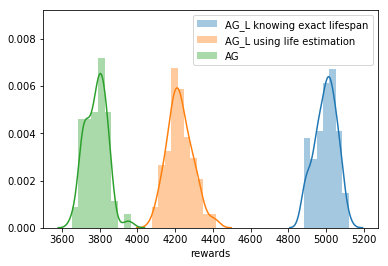

In [46]:
sns.distplot(plt_agl, label='AG_L knowing exact lifespan')
sns.distplot(plt_agl_est, label='AG_L using life estimation')
sns.distplot(plt_ag, label='AG')
plt.legend(loc=1)
plt.ylim(ymax=.0092)
plt.xlabel('rewards')
pass

In [19]:
class UCB_L:
    def __init__(self, records, pool, unborn):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.avg_life = 0
        self.X = 0
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        n_seen = len(self.pool) - len(self.unborn)
        self.X = (self.X * (n_seen-1) + record.clicked) / n_seen
    
    def filter_live(self, t):  
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            self.pool[arm].s = t
            heapq.heappush(self.alive, (self.pool[arm].death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < self.time:
                heapq.heappop(self.alive)    
                dying = self.pool[arm]
                dying.l = t
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
                self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead            
            else:
                break
        return

    def initialize(self, m):
        self.m = m
        i = 0
        while i < m:
            try:
                record = next(self.records) # raise StopIteration
            except StopIteration as si:
                print(si)
                print(record)
                return
            self.time = record.timestamp
            self.filter_live(i)
            if not self.pool[record.id].T: # not played
                self.update(record)
                i += 1
    
    def play(self, n, c=None):
        def score(heap_tuple):
            arm = self.pool[heap_tuple[1]]
            if arm.T:
                T = arm.T
                X = arm.X
            else: # if it's never played, use estimation
                T = 1
                X = self.X
            if not c:
                # if:
                #  not c: not considering remaining life
                # then:
                #  use the original expression that only counts life spent, but not life remaining
                return X + np.sqrt( 2*np.log(self.t - arm.s + 1)/T )
            if c=='vanilla': # vanilla UCB
                return X + np.sqrt( 2*np.log(self.t)/T )
            if not self.avg_life or self.avg_life+arm.s-self.t+1 <= 0:
                # if no estimation or the estimated life length is too small
                # then use 0 as estimated remaining life
                return X
            return X + c*np.log(self.avg_life+arm.s-self.t+1) * np.sqrt(2*np.log(self.t - arm.s+1)/T)
        self.n = n
        for self.t in range(self.m, n):
            while True: # keep trying
                try:
                    record = next(self.records) # raise StopIteration
                except StopIteration as si:
                    print(si)
                    return
                self.time = record.timestamp
                self.filter_live(self.t)
                pick = max(self.alive, key=score)[1]
                if pick == record.id:
                    self.update(record)
                    break

In [17]:
# UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000)
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucb = p.map(player, [i for i in range(100)])

player 0 started
player 25 started
player 5 started
player 20 started
player 15 started
player 10 started
player: 15 reward: 5075 time: 412.3696093559265 records: 1166346
player 16 started
player: 20 reward: 5200 time: 476.16146087646484 records: 2020028
player 21 started
player: 10 reward: 4994 time: 511.876736164093 records: 1141479
player 11 started
player: 5 reward: 5079 time: 539.4996583461761 records: 1208596
player 6 started
player: 0 reward: 5061 time: 545.3572924137115 records: 923051
player 1 started
player: 25 reward: 5235 time: 744.9955775737762 records: -239342
player 26 started
player: 16 reward: 5206 time: 411.89100670814514 records: 1217490
player 17 started
player: 6 reward: 5010 time: 444.83476185798645 records: 1195145
player 7 started
player: 11 reward: 4983 time: 477.6892833709717 records: 1145026
player 12 started
player: 1 reward: 5076 time: 498.34674286842346 records: 941799
player 2 started
player: 21 reward: 5181 time: 686.2287349700928 records: -195809
player

player: 99 reward: 5266 time: 536.9165897369385 records: -459233


In [23]:
with open('save/plt_ucb','wb') as f:
    pickle.dump(plt_ucb, f)

In [25]:
# vanilla UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, 'vanilla')
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start, 'records:', next(ucbl.records).Index-1-i*10000, 'X',ucbl.X, 'avg_life', ucbl.avg_life)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucb_vanilla = p.map(player, [i for i in range(100)])

player 10 started
player 5 started
player 0 started
player 15 started
player 20 started
player 25 started
player: 0 reward: 5076 time: 311.2959213256836 records: 2535296 X 0.04991573113058068 avg_life 40766.35294117647
player 1 started
player: 5 reward: 4999 time: 437.28254103660583 records: 2810906 X 0.01347734389011819 avg_life 35922.083333333336
player 6 started
player: 15 reward: 4984 time: 480.4230329990387 records: 2757491 X 0.11438652461818206 avg_life 37157.256410256414
player 16 started
player: 10 reward: 4990 time: 509.63196849823 records: 2759633 X 0.02247262441272507 avg_life 35917.444444444445
player 11 started
player: 25 reward: 5258 time: 545.9158127307892 records: 3549190 X 0.04947553235511272 avg_life 34492.54716981131
player 26 started
player: 20 reward: 5224 time: 644.9697017669678 records: 3594576 X 0.06535114539896404 avg_life 34603.32075471698
player 21 started
player: 1 reward: 5079 time: 434.95812344551086 records: 2524517 X 0.08161442618610087 avg_life 40692.26

player 67 started
player: 80 reward: 5184 time: 614.8496854305267 records: 3242308 X 0.02285652638915882 avg_life 33465.82142857143
player 81 started
player: 62 reward: 5226 time: 719.2384080886841 records: 3364395 X 0.04155221579629958 avg_life 33245.62962962963
player 63 started
player: 85 reward: 5274 time: 536.1605558395386 records: 3187123 X 0.042924463317194794 avg_life 33559.89285714286
player 86 started
player: 71 reward: 5119 time: 611.7177546024323 records: 3319350 X 0.02898920056143059 avg_life 33632.857142857145
player 72 started
player: 76 reward: 5169 time: 676.100804567337 records: 3288553 X 0.043231339672520415 avg_life 33456.37499999999
player 77 started
player: 86 reward: 5088 time: 547.6951625347137 records: 3284922 X 0.05410295534576298 avg_life 33169.40350877193
player 87 started
player: 63 reward: 5163 time: 596.5061302185059 records: 3351227 X 0.06862766926648071 avg_life 33286.833333333336
player 64 started
player: 67 reward: 5203 time: 715.3436598777771 records

In [26]:
with open('save/plt_ucb_vanilla', 'wb') as f:
    pickle.dump(plt_ucb_vanilla, f)

In [20]:
# UCB_L using life estimation
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, .011)
    end = time.time()
    print('player:',i,'reward:',ucbl.rewards,'time:', end-start, 'records:', next(ucbl.records).Index-1-i*10000, 'X',ucbl.X, 'avg_life', ucbl.avg_life)
    return ucbl.rewards
with Pool(6) as p:
    plt_ucbl_est = p.map(player, [i for i in range(100)])

player 0 started
player 5 started
player 15 started
player 20 started
player 10 started
player 25 started
player: 15 reward: 7323 time: 258.31602716445923 records: 2737483 X 0.11051895556770036 avg_life 36137.32432432433
player 16 started
player: 10 reward: 6952 time: 292.41910886764526 records: 2753146 X 0.08627174791767528 avg_life 35867.166666666664
player 11 started
player: 25 reward: 8215 time: 297.7425465583801 records: 3389708 X 0.10679673267945682 avg_life 34315.96078431373
player 26 started
player: 5 reward: 7311 time: 352.43462467193604 records: 2776494 X 0.07284746768091878 avg_life 36256.305555555555
player 6 started
player: 0 reward: 6494 time: 357.190132856369 records: 2506980 X 0.09595839348279968 avg_life 41310.94117647059
player 1 started
player: 20 reward: 8108 time: 404.7822644710541 records: 3429918 X 0.11206801484614545 avg_life 34387.19607843137
player 21 started
player: 16 reward: 7351 time: 255.84310030937195 records: 2787154 X 0.16596199360968808 avg_life 35961

player 71 started
player: 80 reward: 8612 time: 306.5451958179474 records: 3120463 X 0.11094380044224739 avg_life 32927.67924528302
player 81 started
player: 59 reward: 8414 time: 366.10315680503845 records: 3197790 X 0.07887805467214334 avg_life 34166.69811320755
player 85 started
player: 75 reward: 8611 time: 456.5695743560791 records: 3170463 X 0.11094380044224739 avg_life 32927.67924528302
player 76 started
player: 61 reward: 8624 time: 419.0737376213074 records: 3214927 X 0.12455992740818832 avg_life 33787.50943396227
player 62 started
player: 66 reward: 8485 time: 439.3501226902008 records: 3143711 X 0.12455233655729914 avg_life 34049.339622641506
player 67 started
player: 71 reward: 8589 time: 402.94339895248413 records: 3170299 X 0.09874338460929491 avg_life 33157.20754716981
player 72 started
player: 85 reward: 8578 time: 372.4316942691803 records: 3064854 X 0.05968555261481844 avg_life 32935.56603773585
player 86 started
player: 81 reward: 8611 time: 499.60178804397583 record

In [21]:
with open('save/plt_ucbl_est', 'wb') as f:
    pickle.dump(plt_ucbl_est,f)

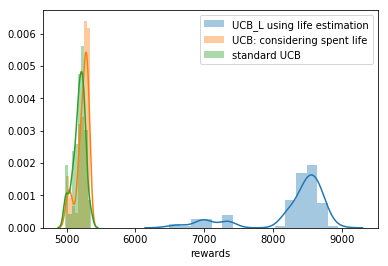

In [27]:
sns.distplot(plt_ucbl_est, label='UCB_L using life estimation')
sns.distplot(plt_ucb, label='UCB: considering spent life')
sns.distplot(plt_ucb_vanilla, label='standard UCB')
plt.legend()
plt.xlabel('rewards')
pass

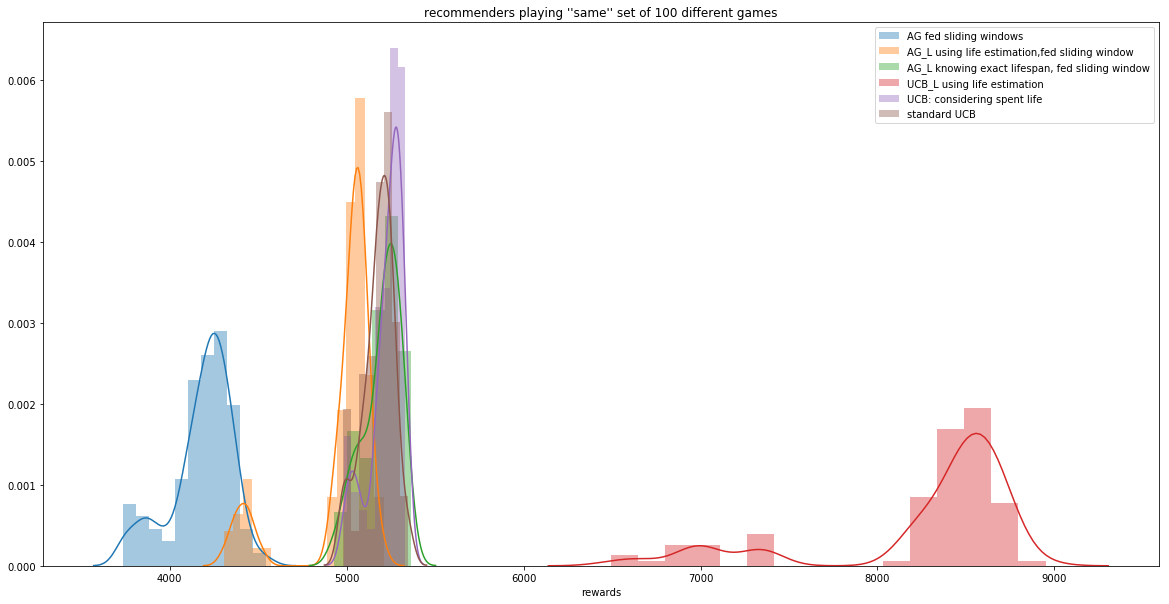

In [33]:
plt.figure(figsize=(20,10))
sns.distplot(plt_ag_sw, label='AG fed sliding windows')
sns.distplot(plt_agl_est_sw, label='AG_L using life estimation,fed sliding window')
sns.distplot(plt_agl_sw, label='AG_L knowing exact lifespan, fed sliding window')
sns.distplot(plt_ucbl_est, label='UCB_L using life estimation')
sns.distplot(plt_ucb, label='UCB: considering spent life')
sns.distplot(plt_ucb_vanilla, label='standard UCB')
plt.legend()
plt.title('''recommenders playing ''same'' set of 100 different games''')
plt.xlabel('rewards')